In [3]:
!pip install -q -U tensorflow-text
!pip install -q tf-models-official==2.4.0
!pip install contractions

     |████████████████████████████████| 4.9 MB 5.2 MB/s 
     |████████████████████████████████| 1.1 MB 5.2 MB/s 
     |████████████████████████████████| 47.6 MB 1.7 MB/s 
     |████████████████████████████████| 1.1 MB 48.1 MB/s 
     |████████████████████████████████| 596 kB 41.8 MB/s 
     |████████████████████████████████| 1.2 MB 46.7 MB/s 
     |████████████████████████████████| 352 kB 47.9 MB/s 
     |████████████████████████████████| 99 kB 8.3 MB/s 
     |████████████████████████████████| 213 kB 47.9 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 321 kB 5.0 MB/s 
     |████████████████████████████████| 284 kB 41.5 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85451 sha256=5206f16ea10466c06e025333a93cdef785285a1022e7d47f74dd2b2d19778aac
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocoras

In [ ]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### **Importing the required libraries**

In [ ]:
import os

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from keras.utils import np_utils

tf.get_logger().setLevel('ERROR')

##**Loading the MBTI Redddit dataset after data augmentation**

In [2]:
data1 = pd.read_csv("MBTI_Reddit_I_E.csv")
print("MBTI dataset with the Binary Labels Introvert/Extrovert(I/E): ")
print("\n")
data1

MBTI dataset with the Binary Labels Introvert/Extrovert(I/E): 




,types,posts
0,e,Yes! Personally I feel that as helpful as it i...
1,e,It is just arguing semantics. To many on the c...
2,e,"Ooohhh okay, I thought there was something els..."
3,i,This was Blizzards way to slow down the meta. ...
4,i,Thank you very much for the support. I am work...
...,...,...
3231,i,Hoi!Heb je nog iemand nodig? Ik kom uit Canad...
3232,i,"""Take care.""A weird, shitty ending to the rela..."
3233,e,$49.46 is how much it costs btw. You can pre-o...
3234,i,You shouldn't use apps to base your assessment...


In [ ]:
import re
import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('words')
words = set(nltk.corpus.words.words())
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
import contractions

def preprocessing(posts):
         
        posts = re.sub('\|\|\|', ' ', posts)
        posts = re.sub('https?://\S+|www\.\S+', '', posts)
        posts = contractions.fix(posts)
        posts = posts.lower()
        posts = re.sub('[0-9]+', '', posts)
        posts = (re.sub(' +', ' ',(posts.replace('\\n','')))).strip()
        posts = re.sub(r'[\.+~*]', ".",posts)
        
        #Remove multiple fullstops
        #posts = re.sub(r'[^\w\s]','',posts)

        #Remove Non-words
        posts = re.sub(r'[^a-zA-Z\s]','',posts)

        #Remove multiple letter repeating words
        #posts = re.sub(r'([a-z])\1{2,}[\s|\w]*','',posts)

        #filtering non-words
        #posts = " ".join(word for word in nltk.wordpunct_tokenize(posts) if word.lower() in words or not word.isalpha())

        stop_words = stopwords.words("english")
        personality_words = ['infj', 'entp', 'intp', 'intj', 'entj', 'enfj', 'infp', 'enfp','isfp', 'istp', 'isfj', 'istj', 'estp', 'esfp', 'estj', 'esfj', 'mbti']
        stop_words.extend(personality_words)
        posts =  ' '.join([w for w in posts.split() if w not in stop_words])

        posts = ' '.join(word for word in posts.split() if len(word)>3)
        lemmatizer = WordNetLemmatizer()
        word_tokens = nltk.word_tokenize(posts)
        posts = ' '.join([lemmatizer.lemmatize(word) for word in word_tokens])        
                
        return posts

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
data1['cleaned_posts'] = data1['posts'].apply(preprocessing)

In [ ]:
from sklearn.preprocessing import LabelEncoder
#from tensorflow.keras.utils import to_categorical

labelencoder_IE = LabelEncoder()

data1['Encoded_labels'] = labelencoder_IE.fit_transform(data1['types'])
data1

,types,posts,cleaned_posts,Encoded_labels
0,e,Yes! Personally I feel that as helpful as it i...,personally feel helpful meticulously plan purc...,0
1,e,It is just arguing semantics. To many on the c...,arguing semantics many consumer beta productio...,0
2,e,"Ooohhh okay, I thought there was something els...",ooohhh okay thought something else thanks vita...,0
3,i,This was Blizzards way to slow down the meta. ...,blizzard slow meta working intended turn alex ...,1
4,i,Thank you very much for the support. I am work...,thank much support working action daily basis ...,1
...,...,...,...,...
3231,i,Hoi!Heb je nog iemand nodig? Ik kom uit Canad...,hoiheb iemand nodig canada maar woon studeer d...,1
3232,i,"""Take care.""A weird, shitty ending to the rela...",take carea weird shitty ending relationship ov...,1
3233,e,$49.46 is how much it costs btw. You can pre-o...,much cost preorder true bear lake socalthis tu...,0
3234,i,You shouldn't use apps to base your assessment...,apps base assessment certain group besides old...,1


In [ ]:
split_1 = int(0.7 * len(data1))
split_2 = int(0.85 * len(data1))

train_ds = data1[:split_1]
val_ds = data1[split_1:split_2]
test_ds = data1[split_2:]

print("Shape of training dataset : ",train_ds.shape)
print("Shape of validation dataset : ",val_ds.shape)
print("Shape of test dataset : ",test_ds.shape)

Shape of training dataset :  (2265, 4)
Shape of validation dataset :  (485, 4)
Shape of test dataset :  (486, 4)


In [ ]:
val_ds

,types,posts,cleaned_posts,Encoded_labels
2265,i,The makeover challenge. They didn't think Cour...,makeover challenge think courtney could great ...,1
2266,i,"I'm sorry, but I'm having trouble understandin...",sorry trouble understanding mean ruperttoothbr...,1
2267,i,I don't see any harm in it. The more you learn...,harm learn better especially come brain operat...,1
2268,i,How old am I?- Late twenties.What state do I l...,late twentieswhat state live would guess calif...,1
2269,i,There is a study that shows a difference in th...,study show difference brain structure male str...,1
...,...,...,...,...
2745,i,Woah! I agree! Handsome fella! I'll have to tr...,woah agree handsome fella next time thanks sou...,1
2746,i,I suppose I'll quit bugging you until I read s...,suppose quit bugging read lineage text game en...,1
2747,i,"""Yeah, I started getting them when I was 2. I...",yeah started getting pretty skanky toddler goo...,1
2748,e,Check tumblrs search base. They tend to have s...,check tumblrs search base tend specific stuff ...,0


In [ ]:
X_val1 = val_ds['cleaned_posts']
y_val1 = val_ds['Encoded_labels']
X_test1 = test_ds['cleaned_posts']
y_test1 = test_ds['Encoded_labels']

In [ ]:
reddit_IE = pd.read_csv("aug_MBTI_BinaryLabels_I_E.csv")
print("The shape of binary dataset (I/E) : ", reddit_IE.shape)
reddit_IE

The shape of binary dataset (I/E) :  (2762, 2)


,types,posts
0,i,lol medyo nag-worry lang ako haha thanks holla...
1,i,That's what most people believe in my store to...
2,i,true that brother What about zombie walk If I ...
3,i,<U+0414><U+0435><U+043F><U+0430><U+0440><U+043...
4,i,Or basically any place you wouldn't want a str...
...,...,...
2757,i,He's too swole to control! Send them my way if...
2758,i,No offense to Giggs but I think Gary would be ...
2759,e,Imma just commenting so I can post questions.....
2760,i,Have you ever watched How to Train Your Dragon...


In [ ]:
reddit_IE['cleaned_posts'] = reddit_IE['posts'].apply(preprocessing)

In [ ]:
labelencoder_IE = LabelEncoder()

reddit_IE['Encoded_labels'] = labelencoder_IE.fit_transform(reddit_IE['types'])
reddit_IE

,types,posts,cleaned_posts,Encoded_labels
0,i,lol medyo nag-worry lang ako haha thanks holla...,medyo nagworry lang haha thanks hollaback girl...,1
1,i,That's what most people believe in my store to...,people believe store work great well another w...,1
2,i,true that brother What about zombie walk If I ...,true brother zombie walk push someone much big...,1
3,i,<U+0414><U+0435><U+043F><U+0430><U+0440><U+043...,youyouyoufyouyouyouyoucyou youyouyou youyoufyo...,1
4,i,Or basically any place you wouldn't want a str...,basically place would want stranger hand haha ...,1
...,...,...,...,...
2757,i,He's too swole to control! Send them my way if...,swole control send mind suffice ilvl can not q...,1
2758,i,No offense to Giggs but I think Gary would be ...,offense giggs think gary would better manager ...,1
2759,e,Imma just commenting so I can post questions.....,imma commenting post question nice dope feel l...,0
2760,i,Have you ever watched How to Train Your Dragon...,ever watched train dragon green eye always wan...,1


In [ ]:
X_train1 = reddit_IE['cleaned_posts']
y_train1 = reddit_IE['Encoded_labels']

In [ ]:
bert_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='inputs')
preprocessing_layer = hub.KerasLayer(bert_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(bert_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
output = outputs['pooled_output']
output = tf.keras.layers.Dropout(0.1)(output)
output = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(output)
model = tf.keras.Model(text_input, output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['inputs[0][0]']                 
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
epochs = 50
batch_size = 32 

train_data_size = len(y_train1)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = optimization.create_optimizer(
  3e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps, optimizer_type='adamw')

In [ ]:
loss = keras.losses.BinaryCrossentropy()
auc = keras.metrics.AUC(multi_label=True, curve="ROC")
metrics=[auc, keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]

In [ ]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

In [ ]:
model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
history = model.fit(
    X_train1, y_train1,
    validation_data=(X_val1, y_val1),
    epochs=epochs,
    batch_size=batch_size, callbacks =[earlystopping], verbose=2)

Epoch 1/50
87/87 - 183s - loss: 0.6697 - auc: 0.4883 - binary_accuracy: 0.6119 - precision: 0.6337 - recall: 0.9327 - val_loss: 0.5528 - val_auc: 0.5276 - val_binary_accuracy: 0.7670 - val_precision: 0.7670 - val_recall: 1.0000 - 183s/epoch - 2s/step
Epoch 2/50
87/87 - 159s - loss: 0.6520 - auc: 0.5474 - binary_accuracy: 0.6343 - precision: 0.6412 - recall: 0.9734 - val_loss: 0.6101 - val_auc: 0.5645 - val_binary_accuracy: 0.7320 - val_precision: 0.7788 - val_recall: 0.9086 - 159s/epoch - 2s/step
Epoch 3/50
87/87 - 158s - loss: 0.6143 - auc: 0.6622 - binary_accuracy: 0.6542 - precision: 0.6739 - recall: 0.8908 - val_loss: 0.5989 - val_auc: 0.5662 - val_binary_accuracy: 0.6763 - val_precision: 0.7778 - val_recall: 0.8091 - 158s/epoch - 2s/step
Epoch 4/50
87/87 - 158s - loss: 0.4754 - auc: 0.8368 - binary_accuracy: 0.7723 - precision: 0.7884 - recall: 0.8807 - val_loss: 0.7220 - val_auc: 0.5750 - val_binary_accuracy: 0.6474 - val_precision: 0.7847 - val_recall: 0.7446 - 158s/epoch - 2s/s

In [ ]:
loss1, auc1, accuracy1, precision1, recall1 = model.evaluate(X_test1, y_test1, batch_size=32, verbose=False)

print("Testing Accuracy: ",accuracy1)
print("Loss : ",loss1)
print("Precision : ",precision1)
print("Recall : ",recall1)
print("AUC : ", auc1)

Testing Accuracy:  0.7530864477157593
Loss :  0.5611630082130432
Precision :  0.7530864477157593
Recall :  1.0
AUC :  0.5725979208946228


In [ ]:
F1_IE = 2 * (precision1 * recall1) / (precision1 + recall1)
print("F1 score for Introvert/Extrovert(I/E): {:.4f}".format(F1_IE))

F1 score for Introvert/Extrovert(I/E): 0.8592


In [ ]:
def plot_history(history):

  history_dict = history.history
  #print(history_dict.keys())

  acc = history_dict['binary_accuracy']
  val_acc = history_dict['val_binary_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)
  plt.figure(figsize=(10, 6))


  plt.subplot(2, 1, 1)
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(2, 1, 2)
  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='upper left')
  plt.tight_layout()

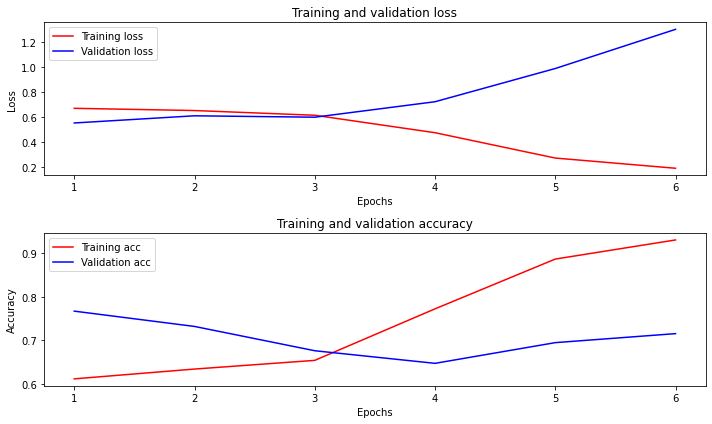

In [ ]:
plot_history(history)

In [ ]:
y_predicted1 = model.predict(X_test1)

In [ ]:
r_probs = [0 for _ in range(len(y_test1))]

r_auc = roc_auc_score(y_test1, r_probs)
roc_model1 = roc_auc_score(y_test1, y_predicted1)
print("Random (chance) prediction : AUROC = %.3f" % (r_auc))
print("IE_Model : AUROC = %.3f" % (roc_model1))

Random (chance) prediction : AUROC = 0.500
IE_Model : AUROC = 0.576


In [ ]:
r_fpr, r_tpr, _ =  roc_curve(y_test1, r_probs)
m1_fpr, m1_tpr, _ = roc_curve(y_test1, y_predicted1)

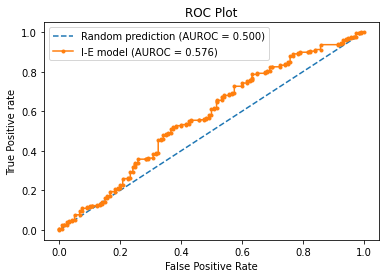

In [ ]:
plt.plot(r_fpr, r_tpr, linestyle='--', label = 'Random prediction (AUROC = %.3f)'% r_auc)
plt.plot(m1_fpr, m1_tpr, marker='.', label = 'I-E model (AUROC = %.3f)'% roc_model1)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend()
plt.show()

In [ ]:
input =  "I like to watch movies and like to travel often with my friends. "
sentences = np.asarray([input])

predict = model.predict(sentences)

print(predict)
if np.where(predict > 0.5):

  print("The Input text is, MBTI type Introvert(I)")
else:
  print("The Input text is MBTI type Extrovert(E)")

[[0.59874874]]
The Input text is, MBTI type Introvert(I)


In [ ]:
input =  "I like to spend my leisure time by reading books in a quiet place. "
sentences = np.asarray([input])

predict = model.predict(sentences)

print(predict)
if np.where(predict > 0.5):

  print("The Input text is, MBTI type Introvert(I)")
else:
  print("The Input text is MBTI type Extrovert(E)")

[[0.5497268]]
The Input text is, MBTI type Introvert(I)


In [ ]:
model.save("I1_model.h5")

In [ ]:
reloaded_model_IE = tf.keras.models.load_model("I1_model.h5", custom_objects={'KerasLayer':hub.KerasLayer , 'AdamWeightDecay': optimizer})

In [ ]:
data2 = pd.read_csv("MBTI_Reddit_S_N.csv")
data2.head()

,types,posts
0,n,Yes! Personally I feel that as helpful as it i...
1,n,It is just arguing semantics. To many on the c...
2,n,"Ooohhh okay, I thought there was something els..."
3,n,This was Blizzards way to slow down the meta. ...
4,n,Thank you very much for the support. I am work...


In [ ]:
data2['cleaned_posts'] = data2['posts'].apply(preprocessing)

In [ ]:
labelencoder_SN = LabelEncoder()

data2['Encoded_labels'] = labelencoder_SN.fit_transform(data2['types'])
data2

,types,posts,cleaned_posts,Encoded_labels
0,n,Yes! Personally I feel that as helpful as it i...,personally feel helpful meticulously plan purc...,0
1,n,It is just arguing semantics. To many on the c...,arguing semantics many consumer beta productio...,0
2,n,"Ooohhh okay, I thought there was something els...",ooohhh okay thought something else thanks vita...,0
3,n,This was Blizzards way to slow down the meta. ...,blizzard slow meta working intended turn alex ...,0
4,n,Thank you very much for the support. I am work...,thank much support working action daily basis ...,0
...,...,...,...,...
3231,n,Hoi!Heb je nog iemand nodig? Ik kom uit Canad...,hoiheb iemand nodig canada maar woon studeer d...,0
3232,n,"""Take care.""A weird, shitty ending to the rela...",take carea weird shitty ending relationship ov...,0
3233,s,$49.46 is how much it costs btw. You can pre-o...,much cost preorder true bear lake socalthis tu...,1
3234,n,You shouldn't use apps to base your assessment...,apps base assessment certain group besides old...,0


In [ ]:
split_1 = int(0.7 * len(data2))
split_2 = int(0.85 * len(data2))

train_ds = data2[:split_1]
val_ds = data2[split_1:split_2]
test_ds = data2[split_2:]

print("Shape of training dataset : ",train_ds.shape)
print("Shape of validation dataset : ",val_ds.shape)
print("Shape of test dataset : ",test_ds.shape)

Shape of training dataset :  (2265, 4)
Shape of validation dataset :  (485, 4)
Shape of test dataset :  (486, 4)


In [ ]:
X_val2 = val_ds['cleaned_posts']
y_val2 = val_ds['Encoded_labels']
X_test2 = test_ds['cleaned_posts']
y_test2 = test_ds['Encoded_labels']

In [ ]:
reddit_SN = pd.read_csv("aug_MBTI_BinaryLabels_S_N.csv")
reddit_SN.head()

,types,posts
0,n,I thought he pulled out...? Perhaps *The Enorm...
1,n,"Any luck in the Milwaukee, WI area? Count me i..."
2,n,You have a better solution to stopping illegal...
3,n,"sorry but, what is bujabuja set? https://www.p..."
4,n,My bro and I managed to hike the peak of that ...


In [ ]:
reddit_SN['cleaned_posts'] = reddit_SN['posts'].apply(preprocessing)

In [ ]:
labelencoder_SN = LabelEncoder()

reddit_SN['Encoded_labels'] = labelencoder_SN.fit_transform(reddit_SN['types'])
reddit_SN

,types,posts,cleaned_posts,Encoded_labels
0,n,I thought he pulled out...? Perhaps *The Enorm...,thought pulled perhaps enormous oliver butterw...,0
1,n,"Any luck in the Milwaukee, WI area? Count me i...",luck milwaukee area count good luck everyone d...,0
2,n,You have a better solution to stopping illegal...,better solution stopping illegal immigrant dru...,0
3,n,"sorry but, what is bujabuja set? https://www.p...",sorry bujabuja thinking creating small game cu...,0
4,n,My bro and I managed to hike the peak of that ...,managed hike peak couple year back much nostal...,0
...,...,...,...,...
2577,n,I fiercely dislike Memoirs of a Geisha. I thin...,fiercely dislike memoir geisha think fine look...,0
2578,n,The Internet or Syd herself I have a feeling i...,internet feeling would golden song thanks repl...,0
2579,n,The seeds are 'spores' that float around in th...,seed spore float around germ willif perfectly ...,0
2580,s,Stephan Kinsella has an interesting paper on t...,stephan kinsella interesting paper subject lib...,1


In [ ]:
X_train2 = reddit_SN['cleaned_posts']
y_train2 = reddit_SN['Encoded_labels']

In [ ]:
epochs = 50
batch_size = 16  

train_data_size = len(y_train2)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = optimization.create_optimizer(
    3e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps, optimizer_type='adamw')

In [ ]:
loss = keras.losses.BinaryCrossentropy()
auc = keras.metrics.AUC(multi_label=True, curve="ROC")
metrics=[auc, keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]

In [ ]:
model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
history = model.fit(
    X_train2, y_train2,
    validation_data=(X_val2, y_val2),
    epochs=epochs,
    batch_size=batch_size, callbacks =[earlystopping], verbose=2)

Epoch 1/50
162/162 - 171s - loss: 0.5519 - auc_2: 0.5706 - binary_accuracy: 0.7545 - precision_2: 0.5000 - recall_2: 0.0016 - val_loss: 0.4555 - val_auc_2: 0.5132 - val_binary_accuracy: 0.8557 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - 171s/epoch - 1s/step
Epoch 2/50
162/162 - 159s - loss: 0.5485 - auc_2: 0.5976 - binary_accuracy: 0.7556 - precision_2: 0.5405 - recall_2: 0.0315 - val_loss: 0.4142 - val_auc_2: 0.5536 - val_binary_accuracy: 0.8557 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - 159s/epoch - 980ms/step
Epoch 3/50
162/162 - 158s - loss: 0.4820 - auc_2: 0.7402 - binary_accuracy: 0.7820 - precision_2: 0.6592 - recall_2: 0.2319 - val_loss: 0.4445 - val_auc_2: 0.5214 - val_binary_accuracy: 0.8495 - val_precision_2: 0.2000 - val_recall_2: 0.0143 - 158s/epoch - 977ms/step
Epoch 4/50
162/162 - 159s - loss: 0.3140 - auc_2: 0.9104 - binary_accuracy: 0.8679 - precision_2: 0.7659 - recall_2: 0.6656 - val_loss: 0.6798 - val_auc_2: 0.5192 - val_binary_accurac

In [ ]:
loss2, auc2, accuracy2, precision2, recall2 = model.evaluate(X_test2, y_test2, batch_size=32, verbose=False)

print("Testing Accuracy: ",accuracy2)
print("Loss : ",loss2)
print("Precision : ",precision2)
print("Recall : ",recall2)
print("AUC : ",auc2)

Testing Accuracy:  0.8662551641464233
Loss :  0.3896915316581726
Precision :  0.0
Recall :  0.0
AUC :  0.5786040425300598


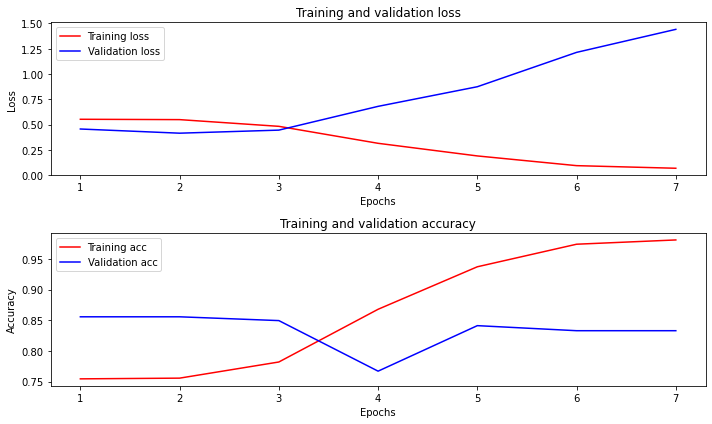

In [ ]:
plot_history(history)

In [ ]:
y_predicted2 = model.predict(X_test2)

In [ ]:
r_probs = [0 for _ in range(len(y_test2))]

r_auc = roc_auc_score(y_test2, r_probs)
roc_model2 = roc_auc_score(y_test2, y_predicted2)
print("Random (chance) prediction : AUROC = %.3f" % (r_auc))
print("SN_Model : AUROC = %.3f" % (roc_model2))

Random (chance) prediction : AUROC = 0.500
SN_Model : AUROC = 0.578


In [ ]:
r_fpr, r_tpr, _ =  roc_curve(y_test2, r_probs)
m2_fpr, m2_tpr, _ = roc_curve(y_test2, y_predicted2)

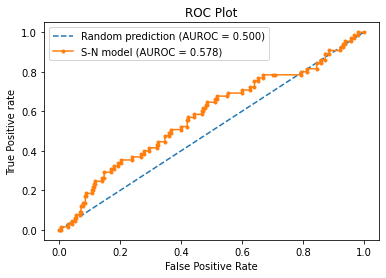

In [ ]:
plt.plot(r_fpr, r_tpr, linestyle='--', label = 'Random prediction (AUROC = %.3f)'% r_auc)
plt.plot(m2_fpr, m2_tpr, marker='.', label = 'S-N model (AUROC = %.3f)'% roc_model2)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend()
plt.show()

In [ ]:
input =  "I like to watch movies and like to travel often with my friends. "
sentences = np.asarray([input])

predict = model.predict(sentences)

print(predict)
if np.where(predict > 0.5):

  print("The Input text is, MBTI type Sensing(S)")
else:
  print("The Input text is MBTI type INtuition(N)")

[[0.51050705]]
The Input text is, MBTI type Sensing(S)


In [ ]:
input =  "I like to spend my leisure time by reading books in a quiet place. "
sentences = np.asarray([input])

predict = model.predict(sentences)

print(predict)
if np.where(predict > 0.5):

  print("The Input text is, MBTI type Sensing(S)")
else:
  print("The Input text is MBTI type INtuition(N)")

[[0.44660288]]
The Input text is, MBTI type Sensing(S)


In [ ]:
model.save("S1_model.h5")

In [ ]:
reloaded_model_SN = tf.keras.models.load_model("S1_model.h5", custom_objects={'KerasLayer':hub.KerasLayer , 'AdamWeightDecay': optimizer})

In [ ]:
data3 = pd.read_csv("MBTI_Reddit_F_T.csv")
data3.head()

,types,posts
0,t,Yes! Personally I feel that as helpful as it i...
1,t,It is just arguing semantics. To many on the c...
2,t,"Ooohhh okay, I thought there was something els..."
3,t,This was Blizzards way to slow down the meta. ...
4,t,Thank you very much for the support. I am work...


In [ ]:
data3['cleaned_posts'] = data3['posts'].apply(preprocessing)

In [ ]:
labelencoder_FT = LabelEncoder()

data3['Encoded_labels'] = labelencoder_FT.fit_transform(data3['types'])
data3

,types,posts,cleaned_posts,Encoded_labels
0,t,Yes! Personally I feel that as helpful as it i...,personally feel helpful meticulously plan purc...,1
1,t,It is just arguing semantics. To many on the c...,arguing semantics many consumer beta productio...,1
2,t,"Ooohhh okay, I thought there was something els...",ooohhh okay thought something else thanks vita...,1
3,t,This was Blizzards way to slow down the meta. ...,blizzard slow meta working intended turn alex ...,1
4,t,Thank you very much for the support. I am work...,thank much support working action daily basis ...,1
...,...,...,...,...
3231,t,Hoi!Heb je nog iemand nodig? Ik kom uit Canad...,hoiheb iemand nodig canada maar woon studeer d...,1
3232,t,"""Take care.""A weird, shitty ending to the rela...",take carea weird shitty ending relationship ov...,1
3233,f,$49.46 is how much it costs btw. You can pre-o...,much cost preorder true bear lake socalthis tu...,0
3234,f,You shouldn't use apps to base your assessment...,apps base assessment certain group besides old...,0


In [ ]:
split_1 = int(0.7 * len(data3))
split_2 = int(0.85 * len(data3))

train_ds = data3[:split_1]
val_ds = data3[split_1:split_2]
test_ds = data3[split_2:]

print("Shape of training dataset : ",train_ds.shape)
print("Shape of validation dataset : ",val_ds.shape)
print("Shape of test dataset : ",test_ds.shape)

Shape of training dataset :  (2265, 4)
Shape of validation dataset :  (485, 4)
Shape of test dataset :  (486, 4)


In [ ]:
X_val3 = val_ds['cleaned_posts']
y_val3 = val_ds['Encoded_labels']
X_test3 =test_ds['cleaned_posts']
y_test3 = test_ds['Encoded_labels']

In [ ]:
reddit_FT = pd.read_csv("aug_MBTI_BinaryLabels_F_T.csv")
reddit_FT.head()

,types,posts
0,t,"Culture Shock, easily for me. No Chance at Dee..."
1,t,Why do you have one? This is so fucking sad. I...
2,f,crystal blue persuasion Why did that even come...
3,f,awesome! Love that! thanks for sharing! :)! Su...
4,t,i see more of a laborador but they're just wha...


In [ ]:
reddit_FT['cleaned_posts'] = reddit_FT['posts'].apply(preprocessing)

In [ ]:
labelencoder_FT = LabelEncoder()

reddit_FT['Encoded_labels'] = labelencoder_FT.fit_transform(reddit_FT['types'])
reddit_FT

,types,posts,cleaned_posts,Encoded_labels
0,t,"Culture Shock, easily for me. No Chance at Dee...",culture shock easily chance deep penetration n...,1
1,t,Why do you have one? This is so fucking sad. I...,fucking even know else could said represented ...,1
2,f,crystal blue persuasion Why did that even come...,crystal blue persuasion even come first place ...,0
3,f,awesome! Love that! thanks for sharing! :)! Su...,awesome love thanks sharing bummer well guess ...,0
4,t,i see more of a laborador but they're just wha...,laborador grew could touch nostalgia scouser a...,1
...,...,...,...,...
3108,f,Get a job immediately out of college. Pretty g...,immediately college pretty great went straight...,0
3109,f,"Example two: I'd say ""the tool"" and reach my h...",example would tool reach hand towards seems re...,0
3110,f,I still don't see any reason to sugarcoat real...,still reason sugarcoat reality anecdotal evide...,0
3111,t,"This is EXACTLY what I think, then I feel pity...",exactly think feel pity best place rinse minut...,1


In [ ]:
X_train3 = reddit_FT['cleaned_posts']
y_train3 = reddit_FT['Encoded_labels']

In [ ]:
epochs = 50
batch_size = 32  

train_data_size = len(y_train3)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = optimization.create_optimizer(
    3e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps, optimizer_type='adamw')

In [ ]:
loss = keras.losses.BinaryCrossentropy()
auc = keras.metrics.AUC(multi_label=True, curve="ROC")
metrics=[auc, keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]

In [ ]:
model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
history = model.fit(
    X_train3, y_train3,
    validation_data=(X_val3, y_val3),
    epochs=epochs,
    batch_size=batch_size, callbacks =[earlystopping], verbose=2)

Epoch 1/50
98/98 - 191s - loss: 0.7673 - auc_3: 0.4879 - binary_accuracy: 0.5249 - precision_3: 0.4456 - recall_3: 0.1793 - val_loss: 0.7153 - val_auc_3: 0.6054 - val_binary_accuracy: 0.4330 - val_precision_3: 0.7500 - val_recall_3: 0.0108 - 191s/epoch - 2s/step
Epoch 2/50
98/98 - 179s - loss: 0.6778 - auc_3: 0.5959 - binary_accuracy: 0.5785 - precision_3: 0.5604 - recall_3: 0.3437 - val_loss: 0.6962 - val_auc_3: 0.6282 - val_binary_accuracy: 0.5649 - val_precision_3: 0.6897 - val_recall_3: 0.4332 - 179s/epoch - 2s/step
Epoch 3/50
98/98 - 179s - loss: 0.6274 - auc_3: 0.6990 - binary_accuracy: 0.6463 - precision_3: 0.6289 - recall_3: 0.5441 - val_loss: 0.6985 - val_auc_3: 0.6335 - val_binary_accuracy: 0.5959 - val_precision_3: 0.6957 - val_recall_3: 0.5199 - 179s/epoch - 2s/step
Epoch 4/50
98/98 - 179s - loss: 0.4701 - auc_3: 0.8565 - binary_accuracy: 0.7832 - precision_3: 0.7748 - recall_3: 0.7382 - val_loss: 0.8728 - val_auc_3: 0.6144 - val_binary_accuracy: 0.5814 - val_precision_3: 0

In [ ]:
loss3,  auc3, accuracy3, precision3, recall3 = model.evaluate(X_test3, y_test3, batch_size=32, verbose=False)

print("Testing Accuracy: ",accuracy3)
print("Loss : ",loss3)
print("Precision : ",precision3)
print("Recall : ",recall3)
print("AUC : ", auc3)

Testing Accuracy:  0.5596708059310913
Loss :  0.6898012161254883
Precision :  0.6932515501976013
Recall :  0.4079422354698181
AUC :  0.6383155584335327


In [ ]:
F1_FT = 2 * (precision3 * recall3) / (precision3 + recall3)
print("F1 score for Feeling/Thinking(F/T): {:.4f}".format(F1_FT))

F1 score for Feeling/Thinking(F/T): 0.5136


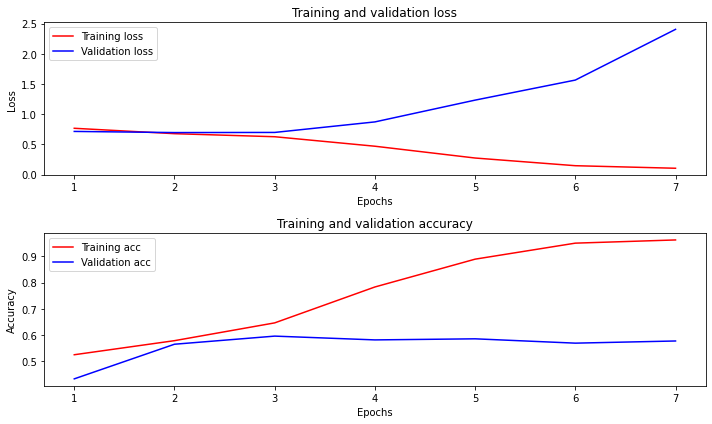

In [ ]:
plot_history(history)

In [ ]:
y_predicted3 = model.predict(X_test3)

In [ ]:
r_probs = [0 for _ in range(len(y_test3))]

r_auc = roc_auc_score(y_test3, r_probs)
roc_model3 = roc_auc_score(y_test3, y_predicted3)
print("Random (chance) prediction : AUROC = %.3f" % (r_auc))
print("FT_Model : AUROC = %.3f" % (roc_model3))

Random (chance) prediction : AUROC = 0.500
FT_Model : AUROC = 0.638


In [ ]:
r_fpr, r_tpr, _ =  roc_curve(y_test3, r_probs)
m3_fpr, m3_tpr, _ = roc_curve(y_test3, y_predicted3)

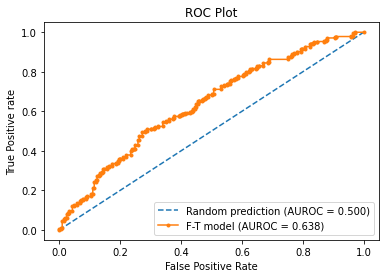

In [ ]:
plt.plot(r_fpr, r_tpr, linestyle='--', label = 'Random prediction (AUROC = %.3f)'% r_auc)
plt.plot(m3_fpr, m3_tpr, marker='.', label = 'F-T model (AUROC = %.3f)'% roc_model3)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend()
plt.show()

In [ ]:
input =  "I like to watch movies and like to travel often with my friends. "
sentences = np.asarray([input])

predict = model.predict(sentences)

print(predict)
if np.where(predict > 0.5):

  print("The Input text is, MBTI type Thinking(T)")
else:
  print("The Input text is MBTI type Feeling(F)")

[[0.54646105]]
The Input text is, MBTI type Thinking(T)


In [ ]:
input =  "I like to spend my leisure time by reading books in a quiet place"
sentences = np.asarray([input])

predict = model.predict(sentences)

print(predict)
if np.where(predict > 0.5):

  print("The Input text is, MBTI type Thinking(T)")
else:
  print("The Input text is MBTI type Feeling(F)")

[[0.52166384]]
The Input text is, MBTI type Thinking(T)


In [ ]:
model.save("F1_model.h5")

In [ ]:
reloaded_model_FT = tf.keras.models.load_model("F1_model.h5", custom_objects={'KerasLayer':hub.KerasLayer , 'AdamWeightDecay': optimizer})

In [ ]:
data4 = pd.read_csv("MBTI_Reddit_J_P.csv")
data4

,types,posts
0,p,Yes! Personally I feel that as helpful as it i...
1,p,It is just arguing semantics. To many on the c...
2,p,"Ooohhh okay, I thought there was something els..."
3,p,This was Blizzards way to slow down the meta. ...
4,p,Thank you very much for the support. I am work...
...,...,...
3231,p,Hoi!Heb je nog iemand nodig? Ik kom uit Canad...
3232,j,"""Take care.""A weird, shitty ending to the rela..."
3233,j,$49.46 is how much it costs btw. You can pre-o...
3234,j,You shouldn't use apps to base your assessment...


In [ ]:
data4['cleaned_posts'] = data4['posts'].apply(preprocessing)

In [ ]:
labelencoder_JP = LabelEncoder()

data4['Encoded_labels'] = labelencoder_JP.fit_transform(data4['types'])
data4

,types,posts,cleaned_posts,Encoded_labels
0,p,Yes! Personally I feel that as helpful as it i...,personally feel helpful meticulously plan purc...,1
1,p,It is just arguing semantics. To many on the c...,arguing semantics many consumer beta productio...,1
2,p,"Ooohhh okay, I thought there was something els...",ooohhh okay thought something else thanks vita...,1
3,p,This was Blizzards way to slow down the meta. ...,blizzard slow meta working intended turn alex ...,1
4,p,Thank you very much for the support. I am work...,thank much support working action daily basis ...,1
...,...,...,...,...
3231,p,Hoi!Heb je nog iemand nodig? Ik kom uit Canad...,hoiheb iemand nodig canada maar woon studeer d...,1
3232,j,"""Take care.""A weird, shitty ending to the rela...",take carea weird shitty ending relationship ov...,0
3233,j,$49.46 is how much it costs btw. You can pre-o...,much cost preorder true bear lake socalthis tu...,0
3234,j,You shouldn't use apps to base your assessment...,apps base assessment certain group besides old...,0


In [ ]:
split_1 = int(0.7 * len(data4))
split_2 = int(0.85 * len(data4))

train_ds = data4[:split_1]
val_ds = data4[split_1:split_2]
test_ds = data4[split_2:]

print("Shape of training dataset : ",train_ds.shape)
print("Shape of validation dataset : ",val_ds.shape)
print("Shape of test dataset : ",test_ds.shape)

Shape of training dataset :  (2265, 4)
Shape of validation dataset :  (485, 4)
Shape of test dataset :  (486, 4)


In [ ]:
X_val4 = val_ds['cleaned_posts']
y_val4 = val_ds['Encoded_labels']
X_test4 =test_ds['cleaned_posts']
y_test4 = test_ds['Encoded_labels']

In [ ]:
reddit_JP = pd.read_csv("aug_MBTI_BinaryLabels_J_P.csv")
reddit_JP

,types,posts
0,p,The production is terrific and James is soundi...
1,p,"Well, I'm a Marine not overseas and I can't wa..."
2,p,Normally...Tried from different angles but I t...
3,j,I don't think we are in much danger of having ...
4,j,You're dealing with crab mentality. Aka crabs ...
...,...,...
3183,p,"Got a degree in philosophy, now I'm a massage ..."
3184,p,if you shut down f-and-f you will also shut do...
3185,p,not a male but i think the length on the sides...
3186,p,"I still don't get the whole ""oh Coraline is so..."


In [ ]:
reddit_JP['cleaned_posts'] = reddit_JP['posts'].apply(preprocessing)

In [ ]:
labelencoder_JP = LabelEncoder()

reddit_JP['Encoded_labels'] = labelencoder_JP.fit_transform(reddit_JP['types'])
reddit_JP

,types,posts,cleaned_posts,Encoded_labels
0,p,The production is terrific and James is soundi...,production terrific james sounding like againt...,1
1,p,"Well, I'm a Marine not overseas and I can't wa...",well marine overseas can not wait watch bronco...,1
2,p,Normally...Tried from different angles but I t...,normallytried different angle think personally...,1
3,j,I don't think we are in much danger of having ...,think much danger likely good mariota option b...,0
4,j,You're dealing with crab mentality. Aka crabs ...,dealing crab mentality crab bucket read never ...,0
...,...,...,...,...
3183,p,"Got a degree in philosophy, now I'm a massage ...",degree philosophy massage therapist pressed fo...,1
3184,p,if you shut down f-and-f you will also shut do...,shut fandf also shut ability make decision nev...,1
3185,p,not a male but i think the length on the sides...,male think length side proportion part good di...,1
3186,p,"I still don't get the whole ""oh Coraline is so...",still whole coraline sooo creepy weird scary c...,1


In [ ]:
X_train4 = reddit_JP['cleaned_posts']
y_train4 = reddit_JP['Encoded_labels']

In [ ]:
epochs = 50
batch_size = 16  

train_data_size = len(y_train4)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = optimization.create_optimizer(
    3e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps, optimizer_type='adamw')

In [ ]:
loss = keras.losses.BinaryCrossentropy()
auc = keras.metrics.AUC(multi_label=True, curve="ROC")
metrics=[auc, keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]

In [ ]:
model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
history = model.fit(
    X_train4, y_train4,
    validation_data=(X_val4, y_val4),
    epochs=epochs,
    batch_size=batch_size, callbacks =[earlystopping], verbose=2)

Epoch 1/50
200/200 - 208s - loss: 0.6955 - auc_4: 0.5214 - binary_accuracy: 0.5483 - precision_4: 0.4377 - recall_4: 0.2563 - val_loss: 0.6967 - val_auc_4: 0.6394 - val_binary_accuracy: 0.4928 - val_precision_4: 0.6613 - val_recall_4: 0.1541 - 208s/epoch - 1s/step
Epoch 2/50
200/200 - 195s - loss: 0.6644 - auc_4: 0.6058 - binary_accuracy: 0.5963 - precision_4: 0.5354 - recall_4: 0.3100 - val_loss: 0.6978 - val_auc_4: 0.6882 - val_binary_accuracy: 0.5526 - val_precision_4: 0.7579 - val_recall_4: 0.2707 - 195s/epoch - 976ms/step
Epoch 3/50
200/200 - 196s - loss: 0.6005 - auc_4: 0.7247 - binary_accuracy: 0.6832 - precision_4: 0.6581 - recall_4: 0.5149 - val_loss: 0.5274 - val_auc_4: 0.8171 - val_binary_accuracy: 0.7423 - val_precision_4: 0.7474 - val_recall_4: 0.8008 - 196s/epoch - 978ms/step
Epoch 4/50
200/200 - 196s - loss: 0.4547 - auc_4: 0.8611 - binary_accuracy: 0.7902 - precision_4: 0.7725 - recall_4: 0.7109 - val_loss: 0.4485 - val_auc_4: 0.8868 - val_binary_accuracy: 0.8144 - val_

In [ ]:
loss4, auc4, accuracy4, precision4, recall4 = model.evaluate(X_test4, y_test4, batch_size=32, verbose=False)

print("Testing Accuracy: ",accuracy4)
print("Loss : ",loss4)
print("Precision : ",precision4)
print("Recall : ",recall4)
print("AUC : ",auc4)

Testing Accuracy:  0.8230452537536621
Loss :  0.42642009258270264
Precision :  0.8184818625450134
Recall :  0.8888888955116272
AUC :  0.8915380835533142


In [ ]:
F1_JP = 2 * (precision4 * recall4) / (precision4 + recall4)
print("F1 score for Judging/Perceiving(J/P): {:.4f}".format(F1_JP))

F1 score for Judging/Perceiving(J/P): 0.8522


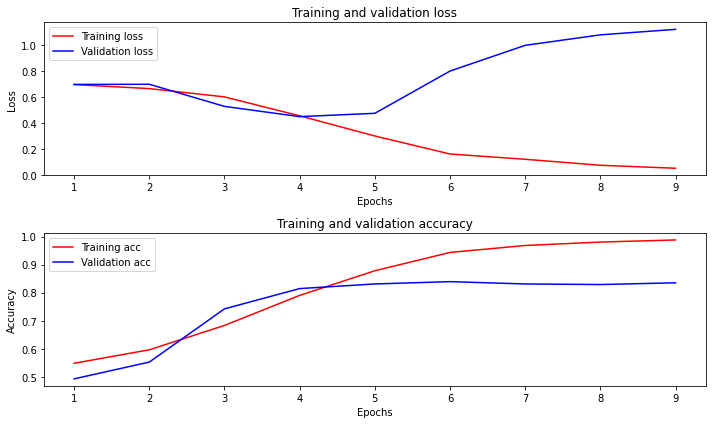

In [ ]:
plot_history(history)

In [ ]:
y_predicted4 = model.predict(X_test4)

In [ ]:
r_probs = [0 for _ in range(len(y_test4))]

r_auc = roc_auc_score(y_test4, r_probs)
roc_model4 = roc_auc_score(y_test2, y_predicted4)
print("Random (chance) prediction : AUROC = %.3f" % (r_auc))
print("JP_Model : AUROC = %.3f" % (roc_model4))

Random (chance) prediction : AUROC = 0.500
JP_Model : AUROC = 0.511


In [ ]:
r_fpr, r_tpr, _ =  roc_curve(y_test4, r_probs)
m4_fpr, m4_tpr, _ = roc_curve(y_test4, y_predicted4)

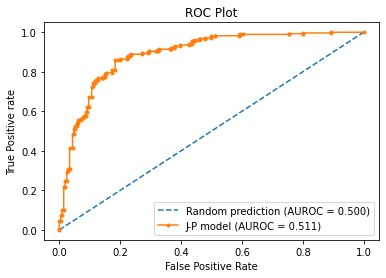

In [ ]:
plt.plot(r_fpr, r_tpr, linestyle='--', label = 'Random prediction (AUROC = %.3f)'% r_auc)
plt.plot(m4_fpr, m4_tpr, marker='.', label = 'J-P model (AUROC = %.3f)'% roc_model4)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend()
plt.show()

In [ ]:
input =  "I like to watch movies and like to travel often with my friends. "
sentences = np.asarray([input])

predict = model.predict(sentences)

print(predict)
if np.where(predict > 0.5):

  print("The Input text is, MBTI type Perceiving(P)")
else:
  print("The Input text is MBTI type Judging(J)")

[[0.61645395]]
The Input text is, MBTI type Perceiving(P)


In [ ]:
input =  "I like to spend my leisure time by reading books in a quiet place."
sentences = np.asarray([input])

predict = model.predict(sentences)

print(predict)
if np.where(predict > 0.5):

  print("The Input text is, MBTI type Perceiving(P)")
else:
  print("The Input text is MBTI type Judging(J)")

[[0.5793138]]
The Input text is, MBTI type Perceiving(P)


In [ ]:
model.save("J1_model.h5")

In [ ]:
reloaded_model_JP = tf.keras.models.load_model("J1_model.h5", custom_objects={'KerasLayer':hub.KerasLayer , 'AdamWeightDecay': optimizer})

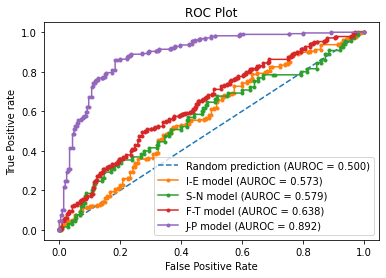

In [ ]:
plt.plot(r_fpr, r_tpr, linestyle='--', label = 'Random prediction (AUROC = %.3f)'% r_auc)
plt.plot(m1_fpr, m1_tpr, marker='.', label = 'I-E model (AUROC = %.3f)'% auc1)
plt.plot(m2_fpr, m2_tpr, marker='.', label = 'S-N model (AUROC = %.3f)'% auc2)
plt.plot(m3_fpr, m3_tpr, marker='.', label = 'F-T model (AUROC = %.3f)'% auc3)
plt.plot(m4_fpr, m4_tpr, marker='.', label = 'J-P model (AUROC = %.3f)'% auc4)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend()
plt.show()

In [ ]:
input =  "he had a great feeling for music."
sentences = np.asarray([input])

predict1 = reloaded_model_IE(sentences)
predict2 = reloaded_model_SN(sentences)
predict3 = reloaded_model_FT(sentences)
predict4 = reloaded_model_JP(sentences)

pred_types = []
scores = []
if np.where(predict1 > 0.5):
  pred_types.append('I')
  scores.append(predict1)
else:
  pred_types.append('E')
  scores.append(predict1)
if np.where(predict1 > 0.5):
  pred_types.append('S')
  scores.append(predict2)
else:
  pred_types.append('N')
  scores.append(predict2)
if np.where(predict1 > 0.5):
  pred_types.append('T')
  scores.append(predict3)
else:
  pred_types.append('F')
  scores.append(predict3)
if np.where(predict1 > 0.5):
  pred_types.append('P')
  scores.append(predict4)
else:
  pred_types.append('J')
  scores.append(predict4)
print('-- comment: ',sentences)
print('\n-- personality: ', pred_types)
print('\n-- scores:', scores)


-- comment:  ['he had a great feeling for music.']

-- personality:  ['I', 'S', 'T', 'P']

-- scores: [<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.6279102]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.53604084]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5901558]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.7029914]], dtype=float32)>]


In [ ]:

models = ["I-E model", "S-N model", "F-T model", "J-P model"]
accuracy = []
precision = []
recall = []
F1_score = []
auc = []
accuracy.append(accuracy1)
accuracy.append(accuracy2)
accuracy.append(accuracy3)
accuracy.append(accuracy4)
precision.append(precision1)
precision.append(precision2)
precision.append(precision3)
precision.append(precision4)
recall.append(recall1)
recall.append(recall2)
recall.append(recall3)
recall.append(recall4)
F1_score.append(F1_IE)
F1_score.append(F1_SN)
F1_score.append(F1_FT)
F1_score.append(F1_JP)
auc.append(roc_model1)
auc.append(roc_model2)
auc.append(roc_model3)
auc.append(roc_model4)

evaluation_metrics = pd.DataFrame()

evaluation_metrics['Models'] = models
evaluation_metrics['Accuracy'] = accuracy
evaluation_metrics['Precision'] = precision
evaluation_metrics['Recall'] = recall
evaluation_metrics['F1 Score'] = F1_score
evaluation_metrics['AUC'] = auc

In [ ]:
evaluation_metrics

,Models,Accuracy,Precision,Recall,F1 Score,AUC
0,I-E model,0.753086,0.753086,1.000000,0.859155,0.575581
1,S-N model,0.866255,0.000000,0.000000,0.000000,0.578019
2,F-T model,0.559671,0.693252,0.407942,0.513636,0.637849
3,J-P model,0.823045,0.818482,0.888889,0.852234,0.510597
